In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Exploratory Data Analysis

In [63]:
#download the data (skip the copyright line) 
data = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2017.txt",delimiter='\t',header=0,skiprows=[1])
data.shape

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(9847443, 26)

In [206]:
# randomly subset 1% of the data (sampling without replacement), this leaves us with ~98,000 samples
data_subset = data.sample(frac=0.01)
data_subset.shape

(98474, 26)

In [207]:
# upon having understood the data, the following columns can be eliminated as they will not be useful for analysis
data_sub = data_subset.drop(['nppes_provider_last_org_name','nppes_provider_first_name','nppes_provider_mi',
                            'hcpcs_description','nppes_credentials','hcpcs_drug_indicator',
                            'nppes_provider_street1','nppes_provider_street2','nppes_provider_city','nppes_provider_zip',
                            'nppes_provider_country'],axis=1)
data_sub.shape

(98474, 15)

### Distributions of features

Text(0,0.5,'Frequency')

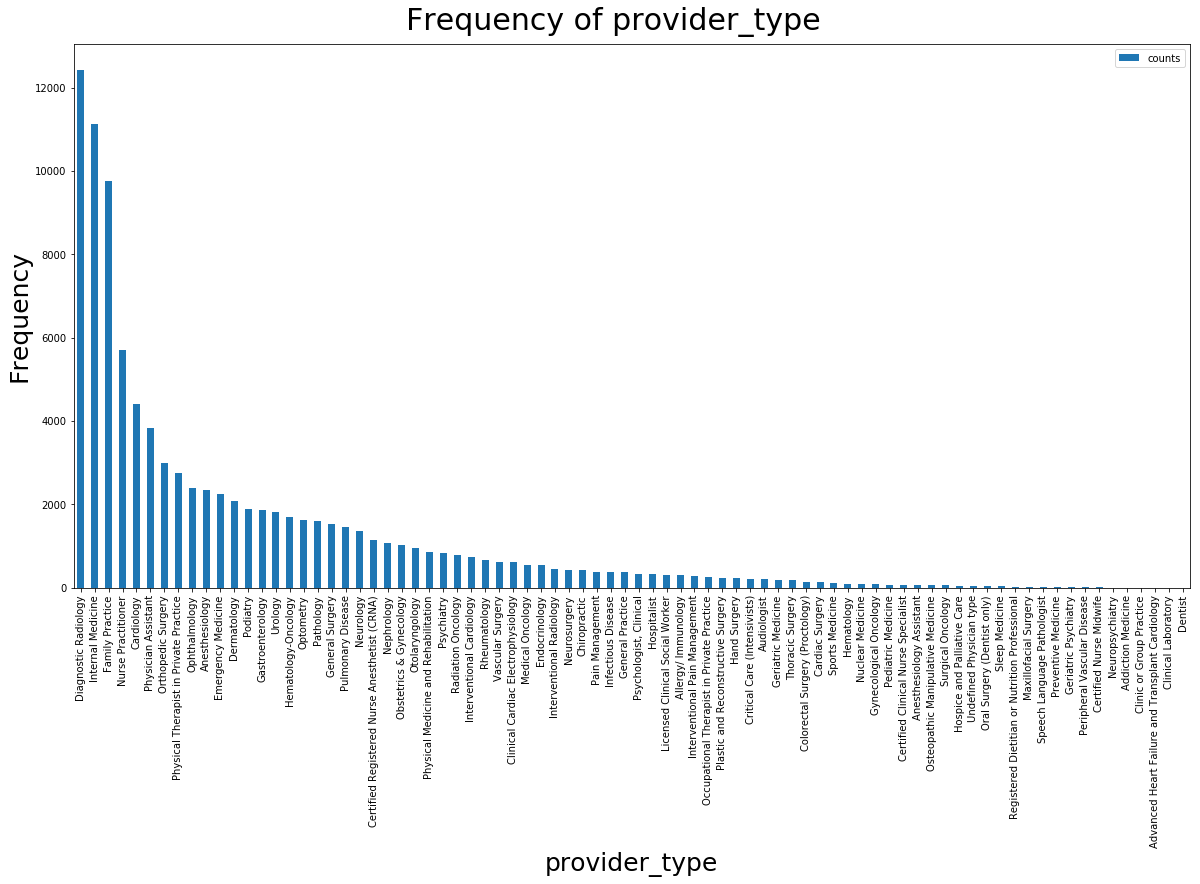

In [156]:
# making sorted bar graph for providers
data_sub.groupby('provider_type').size().reset_index(name='counts').sort_values(by='counts', ascending=False).plot.bar(x = 'provider_type'
                                                                                                                       ,figsize = (20,10))
plt.figtext(.5,.9,'Frequency of provider_type', fontsize=30, ha='center')
plt.xlabel('provider_type', fontsize=25)
plt.ylabel('Frequency', fontsize=25)

Text(0,0.5,'Frequency')

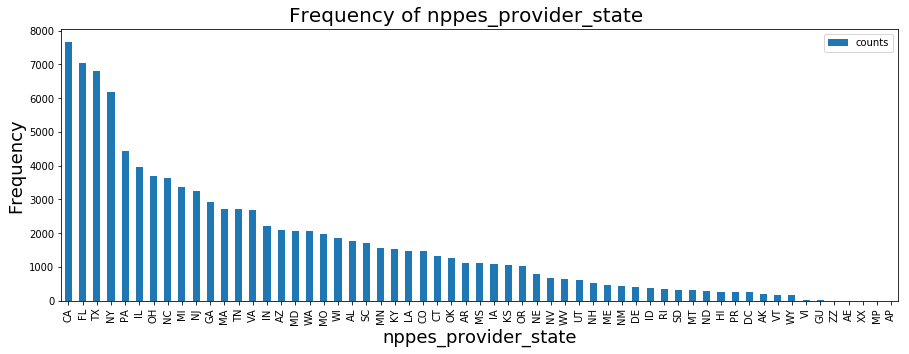

In [81]:
# making sorted bar graph for states
data_sub.groupby('nppes_provider_state').size().reset_index(name='counts').sort_values(by='counts', ascending=False).plot.bar(
                                                                                                                        x = 'nppes_provider_state'
                                                                                                                       ,figsize = (15,5))
plt.figtext(.5,.9,'Frequency of nppes_provider_state', fontsize=20, ha='center')
plt.xlabel('nppes_provider_state', fontsize=18)
plt.ylabel('Frequency', fontsize=18)


Text(0,0.5,'Frequency')

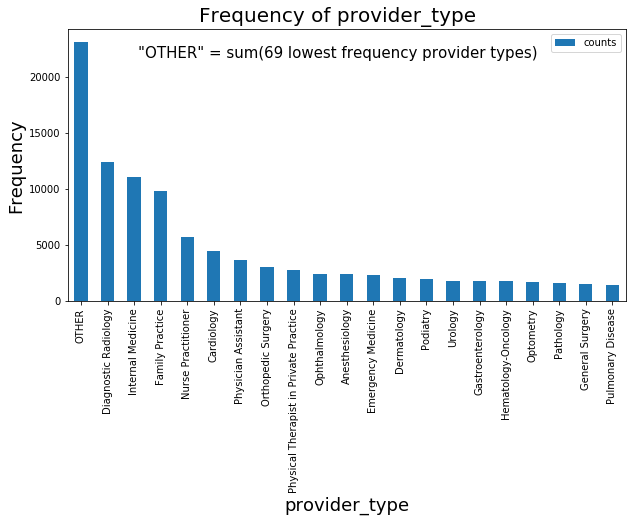

In [98]:
# Creating "Other" bin for provider type data_wo = data_sub.copy()
need = data_sub['provider_type'].value_counts().index[:20]
data_wo['provider_type'] = np.where(data_sub['provider_type'].isin(need), data_sub['provider_type'], 'OTHER')
valCount = data_wo['provider_type'].value_counts()
#print (valCount)

# visualizing effect of "Other" bin for provider_type
df_wo_sort = data_wo.groupby('provider_type').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_wo_sort.plot.bar(x = 'provider_type',figsize = (10,5))
# -> concluded there are too many features for inclusion in answering business question
plt.figtext(.5,.9,'Frequency of provider_type', fontsize=20, ha='center')
plt.figtext(.5,.8,'"OTHER" = sum(' + str( data_sub.provider_type.nunique(dropna = True) - 20) +
                                ' lowest frequency provider types)', fontsize=15, ha='center')
plt.xlabel('provider_type', fontsize=18)
plt.ylabel('Frequency', fontsize=18)



Text(0,0.5,'Frequency')

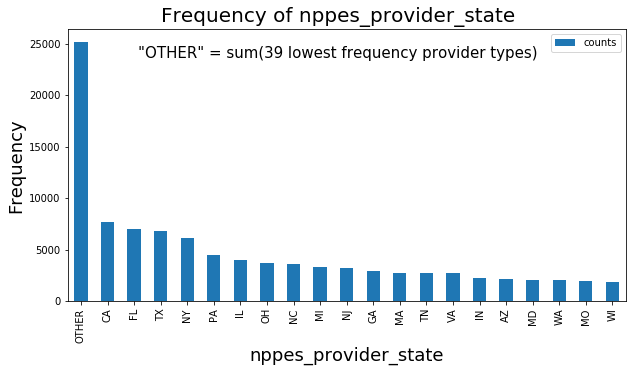

In [100]:
# Creating "Other" bin for provider type data_wo = data_sub.copy()
need = data_sub['nppes_provider_state'].value_counts().index[:20]
data_wo['nppes_provider_state'] = np.where(data_sub['nppes_provider_state'].isin(need), data_sub['nppes_provider_state'], 'OTHER')
valCount = data_wo['nppes_provider_state'].value_counts()
#print (valCount)

# visualizing effect of "Other" bin for provider_type
df_wo_sort = data_wo.groupby('nppes_provider_state').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_wo_sort.plot.bar(x = 'nppes_provider_state',figsize = (10,5))
# -> concluded there are too many features for inclusion in answering business question
plt.figtext(.5,.9,'Frequency of nppes_provider_state', fontsize=20, ha='center')
plt.figtext(.5,.8,'"OTHER" = sum(' + str( data_sub.nppes_provider_state.nunique(dropna = True) - 20) +
                                ' lowest frequency provider types)', fontsize=15, ha='center')
plt.xlabel('nppes_provider_state', fontsize=18)
plt.ylabel('Frequency', fontsize=18)


In [208]:
# splitting states into geographic census regions

# got this dict from: http://code.activestate.com/recipes/580661-states-to-regions/
# also used: https://fcds.med.miami.edu/downloads/DataAcquisitionManual/dam2018/19%20Appendix%20B%20US_Canada_State_Province%20Codes%202018.pdf
states = {
        'AK': 'O','AL': 'S','AR': 'S','AS': 'O','AZ': 'W','CA': 'W','CO': 'W','CT': 'N','DC': 'N','DE': 'N','FL': 'S',
        'GA': 'S','GU': 'O','HI': 'O','IA': 'M','ID': 'W','IL': 'M','IN': 'M','KS': 'M','KY': 'S','LA': 'S','MA': 'N',
        'MD': 'N','ME': 'N','MI': 'W','MN': 'M','MO': 'M','MP': 'O','MS': 'S','MT': 'W','NA': 'O','NC': 'S','ND': 'M',
        'NE': 'W','NH': 'N','NJ': 'N','NM': 'W','NV': 'W','NY': 'N','OH': 'M','OK': 'S','OR': 'W','PA': 'N','PR': 'O',
        'RI': 'N','SC': 'S','SD': 'M','TN': 'S','TX': 'S','UT': 'W','VA': 'S','VI': 'O','VT': 'N','WA': 'W','WI': 'M',
        'WV': 'S','WY': 'W','ZZ': 'O','YY': 'O','XX': 'O','AE': 'O','AP': 'O','AA': 'O','BC': 'O','CD': 'O'
}

data_sub['nppes_census_region'] = data_sub.apply(lambda row: states[row['nppes_provider_state']], axis = 1)
#data_sub.head(10)

Text(0,0.5,'Frequency')

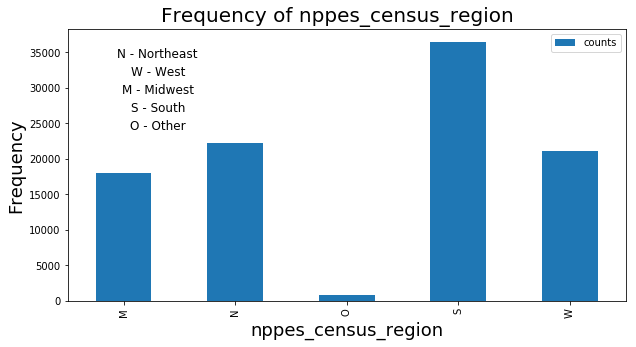

In [111]:
# histogram of regions with histogram
data_sub.groupby('nppes_census_region').size().reset_index(name='counts').plot.bar(x = 'nppes_census_region',figsize = (10,5))
plt.figtext(.5,.9,'Frequency of nppes_census_region', fontsize=20, ha='center')
plt.figtext(.25,.8,'N - Northeast', fontsize=12, ha='center')
plt.figtext(.25,.75,'W - West', fontsize=12, ha='center')
plt.figtext(.25,.7,'M - Midwest', fontsize=12, ha='center')
plt.figtext(.25,.65,'S - South', fontsize=12, ha='center')
plt.figtext(.25,.6,'O - Other', fontsize=12, ha='center')
plt.xlabel('nppes_census_region', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

Text(0,0.5,'Frequency')

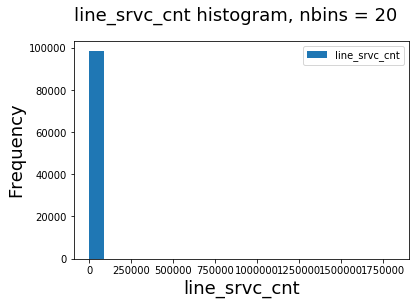

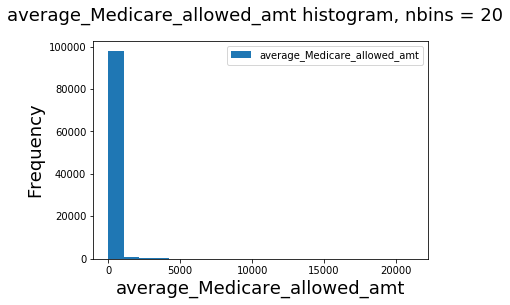

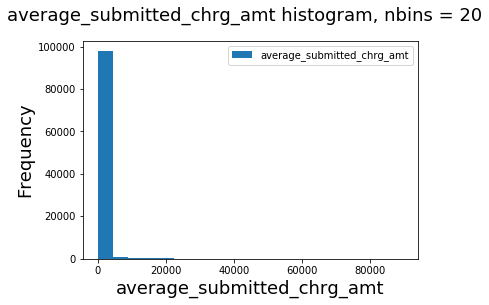

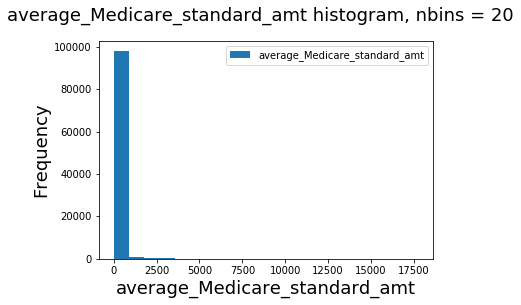

In [117]:
# histogram of line_srvc_cnt
data_sub[['line_srvc_cnt']].plot.hist(bins=20)
plt.figtext(.5,.95,'line_srvc_cnt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('line_srvc_cnt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_Medicare_allowed_amt
data_sub[['average_Medicare_allowed_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_Medicare_allowed_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_Medicare_allowed_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_submitted_chrg_amt
data_sub[['average_submitted_chrg_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_submitted_chrg_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_submitted_chrg_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_Medicare_standard_amt
data_sub[['average_Medicare_standard_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_Medicare_standard_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_Medicare_standard_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

In [209]:
# upon removing uncommon/NaNs // using observations from SQL

# we want to look at the effect of gender as a provider so should remove NaN
data_sub = data_sub.loc[data_sub['nppes_provider_gender'].isin(['M','F'])] 
data_sub = data_sub.loc[data_sub['place_of_service'].isin(['F','O'])] 
data_sub = data_sub.loc[data_sub['nppes_entity_code'].isin(['I','O'])] 

# the N's are less than 0.0005% of the data (observation from SQL)
data_sub = data_sub.loc[data_sub['medicare_participation_indicator'].isin(['Y'])]  
# in SQL: SELECT medicare_participation_indicator,count(medicare_participation_indicator) from medicarePUF GROUP by medicare_participation_indicator ;

# the O's are less than ~5% of the data (observation from SQL) 
# -> choose to keep this since Organizations have drastically higher line service counts as opposed to individuals
#data_sub = data_sub.loc[data_sub['nppes_entity_code'].isin(['I'])]  
# in SQL: SELECT nppes_entity_code, count(nppes_entity_code) from medicarePUF GROUP by nppes_entity_code ;

# source of outlier(s) is hcpcs_code='J0878' according to SQL 
# -> chose to keep this data however, these records are for infectious diseaese vaccinations
# which are high service count while having very low cost, which agrees with the data 
#data_sub = data_sub.loc[data_sub['hcpcs_code'] != 'J0878']
data_sub.head()

,npi,nppes_provider_gender,nppes_entity_code,nppes_provider_state,provider_type,medicare_participation_indicator,place_of_service,hcpcs_code,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_census_region
2776927,1285616573,M,I,CO,Nephrology,Y,O,81002,43.0,39,43,3.500000,18.000000,3.350233,3.430000,W
9610402,1972636843,F,I,PA,Physician Assistant,Y,O,11101,135.0,74,80,27.450000,196.500000,20.971852,21.696370,N
8375232,1851305916,M,I,MO,Urology,Y,O,51741,77.0,64,77,11.708831,269.000000,8.673247,9.538961,M
3558274,1366415960,M,I,NJ,Gastroenterology,Y,O,99202,30.0,30,30,81.490000,247.066667,57.439667,53.212333,N
6789270,1689866493,F,I,MI,Colorectal Surgery (Proctology),Y,F,45380,24.0,23,24,177.625417,827.000000,128.538750,131.240417,W


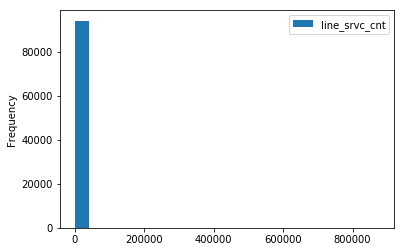

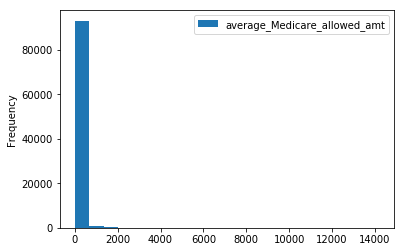

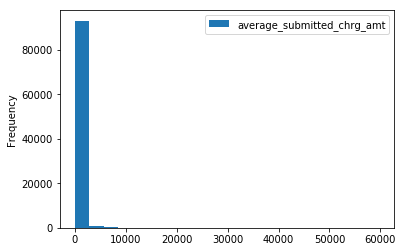

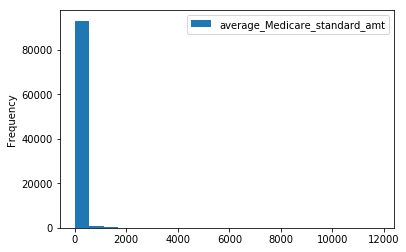

In [83]:
# histogram of line_srvc_cnt
data_sub[['line_srvc_cnt']].plot.hist(bins=20)
plt.figtext(.5,.95,'line_srvc_cnt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('line_srvc_cnt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_Medicare_allowed_amt
data_sub[['average_Medicare_allowed_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_Medicare_allowed_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_Medicare_allowed_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_submitted_chrg_amt
data_sub[['average_submitted_chrg_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_submitted_chrg_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_submitted_chrg_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# histogram of average_Medicare_standard_amt
data_sub[['average_Medicare_standard_amt']].plot.hist(bins=20)
plt.figtext(.5,.95,'average_Medicare_standard_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_Medicare_standard_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# -> can see that these are all skewed far to the left even after removing uncommon data
# -> all need to be standardized and normalized if used

In [213]:
df = data_sub.copy()
df.head()

,npi,nppes_provider_gender,nppes_entity_code,nppes_provider_state,provider_type,medicare_participation_indicator,place_of_service,hcpcs_code,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_census_region
2776927,1285616573,M,I,CO,Nephrology,Y,O,81002,43.0,39,43,3.500000,18.000000,3.350233,3.430000,W
9610402,1972636843,F,I,PA,Physician Assistant,Y,O,11101,135.0,74,80,27.450000,196.500000,20.971852,21.696370,N
8375232,1851305916,M,I,MO,Urology,Y,O,51741,77.0,64,77,11.708831,269.000000,8.673247,9.538961,M
3558274,1366415960,M,I,NJ,Gastroenterology,Y,O,99202,30.0,30,30,81.490000,247.066667,57.439667,53.212333,N
6789270,1689866493,F,I,MI,Colorectal Surgery (Proctology),Y,F,45380,24.0,23,24,177.625417,827.000000,128.538750,131.240417,W


Text(0,0.5,'Frequency')

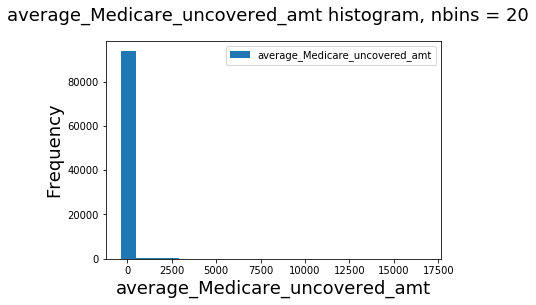

In [214]:
# make gap unpaid variable - this is the total uncovered amount per beneficiary on average in a year for each provider
df['average_Medicare_uncovered_amt'] = data_sub.apply(lambda row: row.line_srvc_cnt*(row.average_Medicare_allowed_amt - 
                                                                                     row.average_Medicare_standard_amt)
                                                                      /row.bene_unique_cnt, axis = 1)
# histogram of average_Medicare_uncovered_amt
df[['average_Medicare_uncovered_amt']].plot.hist(bins=21)
plt.figtext(.5,.95,'average_Medicare_uncovered_amt histogram, nbins = 20', fontsize=18, ha='center')
plt.xlabel('average_Medicare_uncovered_amt', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

### Correlations between features

In [215]:
# Perform one-hot encoding

# one-hot for nppes_census_region 
df = pd.concat([df,pd.get_dummies(df['nppes_census_region'],prefix='nppes_census_region')],axis=1)
df.drop(['nppes_census_region'],axis=1, inplace=True)
df.head(10)

# one-hot for place_of_service
df = pd.concat([df,pd.get_dummies(df['place_of_service'],prefix='place_of_service')],axis=1)
df.drop(['place_of_service'],axis=1, inplace=True)

# one-hot nppes_provider_gender
df = pd.concat([df,pd.get_dummies(df['nppes_provider_gender'],prefix='nppes_provider_gender')],axis=1)
df.drop(['nppes_provider_gender'],axis=1, inplace=True)

In [216]:
# look at ALL correlations
df_corr = df.copy()
df_corr.drop(['npi','nppes_entity_code','nppes_provider_state','provider_type','medicare_participation_indicator','hcpcs_code']
            ,axis=1, inplace=True)
df_corr.corr()

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,average_Medicare_uncovered_amt,nppes_census_region_M,nppes_census_region_N,nppes_census_region_O,nppes_census_region_S,nppes_census_region_W,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M
line_srvc_cnt,1.000000,0.062860,0.101795,-0.015953,-0.015585,-0.015694,-0.015630,0.186680,-0.009255,-0.003042,-0.002723,0.012933,-0.002825,-0.029968,0.029968,-0.006412,0.006412
bene_unique_cnt,0.062860,1.000000,0.796878,-0.040628,-0.054489,-0.042105,-0.042140,-0.015880,-0.023463,-0.000598,-0.012749,0.031002,-0.011170,-0.031839,0.031839,-0.048223,0.048223
bene_day_srvc_cnt,0.101795,0.796878,1.000000,-0.047282,-0.064355,-0.048624,-0.048388,0.049246,-0.026330,0.010475,-0.008947,0.017308,-0.004329,-0.083066,0.083066,-0.027687,0.027687
average_Medicare_allowed_amt,-0.015953,-0.040628,-0.047282,1.000000,0.736201,0.998162,0.993972,0.344168,-0.018641,0.008343,0.001935,-0.004651,0.014330,0.080614,-0.080614,-0.055850,0.055850
average_submitted_chrg_amt,-0.015585,-0.054489,-0.064355,0.736201,1.000000,0.736408,0.727882,0.231266,-0.005631,0.008059,-0.000326,0.002303,-0.005534,0.175188,-0.175188,-0.060880,0.060880
average_Medicare_payment_amt,-0.015694,-0.042105,-0.048624,0.998162,0.736408,1.000000,0.993784,0.341997,-0.018222,0.009071,0.000547,-0.004629,0.013434,0.083465,-0.083465,-0.054677,0.054677
average_Medicare_standard_amt,-0.015630,-0.042140,-0.048388,0.993972,0.727882,0.993784,1.000000,0.328102,-0.013237,-0.003616,0.000376,0.006653,0.008362,0.080637,-0.080637,-0.055535,0.055535
average_Medicare_uncovered_amt,0.186680,-0.015880,0.049246,0.344168,0.231266,0.341997,0.328102,1.000000,-0.018177,0.022737,0.002723,-0.015116,0.011384,-0.025205,0.025205,-0.013798,0.013798
nppes_census_region_M,-0.009255,-0.023463,-0.026330,-0.018641,-0.005631,-0.018222,-0.013237,-0.018177,1.000000,-0.257708,-0.038692,-0.366442,-0.247930,0.040545,-0.040545,0.015259,-0.015259
nppes_census_region_N,-0.003042,-0.000598,0.010475,0.008343,0.008059,0.009071,-0.003616,0.022737,-0.257708,1.000000,-0.043655,-0.413445,-0.279731,0.001683,-0.001683,0.036391,-0.036391


In [192]:
df_corr1 = df.copy()
df_corr1.drop(['npi','nppes_entity_code','nppes_provider_state','provider_type','medicare_participation_indicator','hcpcs_code']
            ,axis=1, inplace=True)
# only look at correlations between relevant numeric variables
df_corr1.drop(['nppes_census_region_M','nppes_census_region_N','nppes_census_region_O','nppes_census_region_S',
              'nppes_census_region_W','place_of_service_O','place_of_service_F','nppes_provider_gender_F',
              'nppes_provider_gender_M','bene_unique_cnt','bene_day_srvc_cnt','average_submitted_chrg_amt',
              'average_Medicare_payment_amt'],axis=1, inplace=True)
df_corr1.corr()

,line_srvc_cnt,average_Medicare_allowed_amt,average_Medicare_standard_amt,average_Medicare_uncovered_amt
line_srvc_cnt,1.000000,-0.024499,-0.024230,0.265360
average_Medicare_allowed_amt,-0.024499,1.000000,0.994834,0.352463
average_Medicare_standard_amt,-0.024230,0.994834,1.000000,0.340548
average_Medicare_uncovered_amt,0.265360,0.352463,0.340548,1.000000


In [193]:
df_corr2 = df.copy()
df_corr2.drop(['npi','nppes_entity_code','nppes_provider_state','provider_type','medicare_participation_indicator','hcpcs_code']
            ,axis=1, inplace=True)
# only look at correlations between relevant numeric variables
df_corr2.drop(['place_of_service_O','place_of_service_F','nppes_provider_gender_F','nppes_census_region_O',
              'nppes_provider_gender_M','bene_unique_cnt','bene_day_srvc_cnt','average_submitted_chrg_amt',
              'average_Medicare_payment_amt','average_Medicare_allowed_amt','average_Medicare_standard_amt',
              'line_srvc_cnt'],axis=1, inplace=True)
df_corr2.corr()

,average_Medicare_uncovered_amt,nppes_census_region_M,nppes_census_region_N,nppes_census_region_S,nppes_census_region_W
average_Medicare_uncovered_amt,1.000000,-0.014043,0.021319,-0.016214,0.010610
nppes_census_region_M,-0.014043,1.000000,-0.257610,-0.359984,-0.245173
nppes_census_region_N,0.021319,-0.257610,1.000000,-0.417632,-0.284434
nppes_census_region_S,-0.016214,-0.359984,-0.417632,1.000000,-0.397469
nppes_census_region_W,0.010610,-0.245173,-0.284434,-0.397469,1.000000


#### Correlations of specific interest 

Text(0,0.5,'average_Medicare_uncovered_amt')

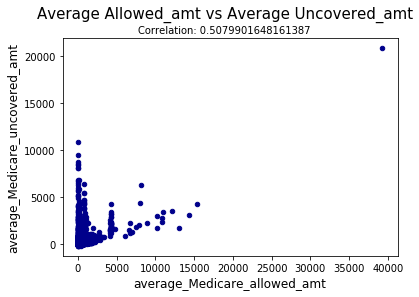

In [155]:
# check correlation between allowable and uncovered amt
df['average_Medicare_allowed_amt'].corr(df['average_Medicare_uncovered_amt'])
df.plot.scatter(x='average_Medicare_allowed_amt',y='average_Medicare_uncovered_amt',c='DarkBlue')
plt.figtext(.5,.95,'Average Allowed_amt vs Average Uncovered_amt', fontsize=15, ha='center')
plt.figtext(.5,.9,'Correlation: ' + str(df['average_Medicare_allowed_amt'].corr(df['average_Medicare_uncovered_amt']))
            , fontsize=10, ha='center')
plt.xlabel('average_Medicare_allowed_amt', fontsize=12)
plt.ylabel('average_Medicare_uncovered_amt', fontsize=12)

Text(0,0.5,'average_Medicare_uncovered_amt')

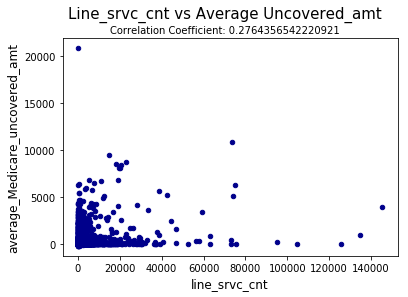

In [154]:
# check correlation between line_srvc_cnt and uncovered amt
df.plot.scatter(x='line_srvc_cnt',y='average_Medicare_uncovered_amt',c='DarkBlue')
plt.figtext(.5,.95,'Line_srvc_cnt vs Average Uncovered_amt', fontsize=15, ha='center')
plt.figtext(.5,.9,'Correlation: ' + str(df['line_srvc_cnt'].corr(df['average_Medicare_uncovered_amt']))
            , fontsize=10, ha='center')
plt.xlabel('line_srvc_cnt', fontsize=12)
plt.ylabel('average_Medicare_uncovered_amt', fontsize=12)

In [217]:
# final drop of columns before moving to clustering
df_corr.drop(['bene_unique_cnt','bene_day_srvc_cnt','average_submitted_chrg_amt','average_Medicare_payment_amt', 
              'line_srvc_cnt','average_Medicare_allowed_amt','average_Medicare_standard_amt','nppes_census_region_O'],axis=1, inplace=True)
df_reg = df_corr.copy()
df_corr.drop(['nppes_census_region_M','nppes_census_region_N',
              'nppes_census_region_S','nppes_census_region_W'],axis=1, inplace=True)
df_corr.head()

,average_Medicare_uncovered_amt,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M
2776927,0.077179,0,1,0,1
9610402,10.496486,0,1,1,0
8375232,2.610625,0,1,0,1
3558274,28.277667,0,1,0,1
6789270,48.401739,1,0,1,0


# Clustering

In [218]:
df_reg.head() 
#df_corr.head()

,average_Medicare_uncovered_amt,nppes_census_region_M,nppes_census_region_N,nppes_census_region_S,nppes_census_region_W,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M
2776927,0.077179,0,0,0,1,0,1,0,1
9610402,10.496486,0,1,0,0,0,1,1,0
8375232,2.610625,1,0,0,0,0,1,0,1
3558274,28.277667,0,1,0,0,0,1,0,1
6789270,48.401739,0,0,0,1,1,0,1,0


#### Standardize and Normalize 

In [219]:
scaler = preprocessing.StandardScaler().fit(df_corr)
dfNorm = scaler.transform(df_corr)
#print(dfNorm)
#len(dfNorm)

### K-means Clustering and evaluating with SSE

In [220]:
import time
# clustering w/ sse
maxClusters = 20
sse = []
start_time = time.time()
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)
    
    time_taken = time.time() - start_time
    print([nClusters,time_taken])

[2, 0.5585036277770996]
[3, 1.1319704055786133]
[4, 1.9039063453674316]
[5, 3.474707841873169]
[6, 4.838060617446899]
[7, 6.539511203765869]
[8, 9.513559103012085]
[9, 13.338330745697021]
[10, 18.00884175300598]
[11, 22.02709674835205]
[12, 27.175330877304077]
[13, 32.66066312789917]
[14, 38.63668346405029]
[15, 45.62435340881348]
[16, 52.172842025756836]
[17, 74.40334296226501]
[18, 90.13009786605835]
[19, 101.5636534690857]


Text(0,0.5,'SSE')

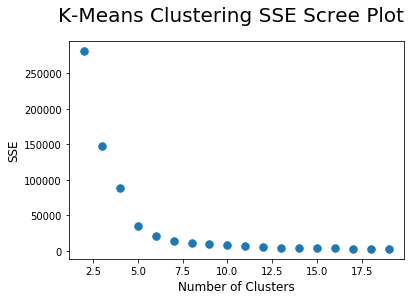

In [221]:
# scree plot for SSE
num_of_clusters = range(2,maxClusters)
plt.plot(num_of_clusters,sse,ls=' ',marker='.',markersize=15)
plt.figtext(.5,.95,'K-Means Clustering SSE Scree Plot', fontsize=20, ha='center')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('SSE', fontsize=12)

### K-means Clustering and evaluating with Silhouette

In [222]:
import time
# clustering w/ silhouette
maxClusters = 20
silh = []
start_time = time.time()
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silh.append(silhouette_score(dfNorm, kmeans.labels_,sample_size=round(len(dfNorm)*0.1)))
    time_taken = time.time() - start_time
    print([nClusters,time_taken])
    

[2, 3.6324691772460938]
[3, 7.350029230117798]
[4, 11.194862365722656]
[5, 15.79525899887085]
[6, 20.20222234725952]
[7, 24.93070363998413]
[8, 30.975626707077026]
[9, 37.9082396030426]
[10, 45.589245557785034]
[11, 52.614726543426514]
[12, 60.31955075263977]
[13, 68.73224186897278]
[14, 77.61239171028137]
[15, 87.50032687187195]
[16, 96.91057419776917]
[17, 109.191969871521]
[18, 121.50572919845581]
[19, 134.57099390029907]


Text(0,0.5,'Silhouette Score')

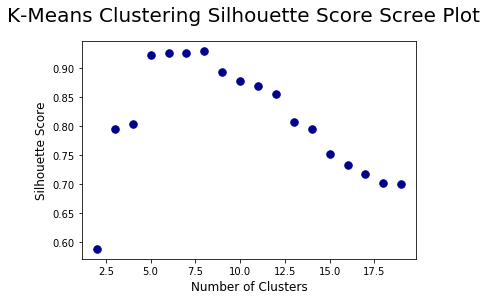

In [223]:
# Scree plot for Silhouette scores
num_of_clusters = range(2,maxClusters)
plt.plot(range(2,maxClusters),silh,c='DarkBlue',ls=' ',marker='.',markersize=15)
plt.figtext(.5,.95,'K-Means Clustering Silhouette Score Scree Plot', fontsize=20, ha='center')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

In [224]:
# optimal number of clusters from silhouette
num_clusters_list = range(2,maxClusters)
best_num_clusters = num_clusters_list[silh.index(max(silh))]
print(best_num_clusters)

8


In [230]:
# add column with Cluster assignment
kmeans = KMeans(n_clusters=best_num_clusters, random_state=0).fit(dfNorm)
dat = pd.concat([df_corr,pd.DataFrame(kmeans.labels_,columns=["Cluster"]).set_index(df_corr.index)],axis=1)
dat.head()

,average_Medicare_uncovered_amt,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M,Cluster
2776927,0.077179,0,1,0,1,1
9610402,10.496486,0,1,1,0,2
8375232,2.610625,0,1,0,1,1
3558274,28.277667,0,1,0,1,1
6789270,48.401739,1,0,1,0,3


In [231]:
dat['Cluster'].value_counts()

1    37445
0    27634
2    19299
3     9374
7      258
5       83
4       42
6        3
Name: Cluster, dtype: int64

In [242]:
dat.groupby('Cluster').mean()

,average_Medicare_uncovered_amt,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M
Cluster,,,,,
0,33.811369,1.000000,0.000000,0.000000,1.000000
1,31.026857,0.000000,1.000000,0.000000,1.000000
2,28.645668,0.000000,1.000000,1.000000,0.000000
3,30.190208,1.000000,0.000000,1.000000,0.000000
4,5483.346626,0.000000,1.000000,0.238095,0.761905
5,2540.776330,0.000000,1.000000,0.313253,0.686747
6,14432.842500,0.000000,1.000000,0.000000,1.000000
7,892.119065,0.069767,0.930233,0.217054,0.782946


### Examine cluster-to-region relationship

In [236]:
# to examine regional relationship if any 
dat_test = pd.concat([df_reg
                   ,pd.DataFrame(kmeans.labels_,columns=["Cluster"]).set_index(df_reg.index)]
                   ,axis=1)

dat_test.head()

,average_Medicare_uncovered_amt,nppes_census_region_M,nppes_census_region_N,nppes_census_region_S,nppes_census_region_W,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M,Cluster
2776927,0.077179,0,0,0,1,0,1,0,1,1
9610402,10.496486,0,1,0,0,0,1,1,0,2
8375232,2.610625,1,0,0,0,0,1,0,1,1
3558274,28.277667,0,1,0,0,0,1,0,1,1
6789270,48.401739,0,0,0,1,1,0,1,0,3


In [240]:
dat_test1 = dat_test.copy()

dat_test1.drop(['place_of_service_F','place_of_service_O',
             'nppes_provider_gender_F','nppes_provider_gender_M'],axis=1, inplace=True)

dat_test1.groupby('Cluster').mean()

,average_Medicare_uncovered_amt,nppes_census_region_M,nppes_census_region_N,nppes_census_region_S,nppes_census_region_W
Cluster,,,,,
0,33.811369,0.205146,0.211298,0.366903,0.210393
1,31.026857,0.165389,0.217839,0.389878,0.220109
2,28.645668,0.189440,0.237940,0.361210,0.204985
3,30.190208,0.206849,0.269362,0.320674,0.196821
4,5483.346626,0.095238,0.261905,0.452381,0.190476
5,2540.776330,0.132530,0.168675,0.445783,0.240964
6,14432.842500,0.333333,0.333333,0.333333,0.000000
7,892.119065,0.120155,0.259690,0.313953,0.298450


In [241]:
dat_test2 = dat_test.copy()

dat_test2.drop(['nppes_census_region_M','nppes_census_region_N',
              'nppes_census_region_S','nppes_census_region_W'],axis=1, inplace=True)

dat_test2.groupby('Cluster').mean()

,average_Medicare_uncovered_amt,place_of_service_F,place_of_service_O,nppes_provider_gender_F,nppes_provider_gender_M
Cluster,,,,,
0,33.811369,1.000000,0.000000,0.000000,1.000000
1,31.026857,0.000000,1.000000,0.000000,1.000000
2,28.645668,0.000000,1.000000,1.000000,0.000000
3,30.190208,1.000000,0.000000,1.000000,0.000000
4,5483.346626,0.000000,1.000000,0.238095,0.761905
5,2540.776330,0.000000,1.000000,0.313253,0.686747
6,14432.842500,0.000000,1.000000,0.000000,1.000000
7,892.119065,0.069767,0.930233,0.217054,0.782946
